In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Googlenet Architecture

![](https://media.geeksforgeeks.org/wp-content/uploads/20200429201421/Inception-layer-by-layer.PNG)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10     
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
import glob   
import cv2  
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
!pip install opencv-python

In [4]:
image = cv2.imread('/kaggle/input/alzheimer-mri-dataset/Dataset/Non_Demented/non.jpg')

In [5]:
image.shape

(128, 128, 3)

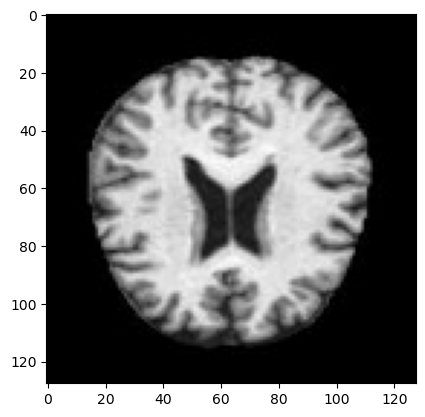

In [6]:
plt.imshow(image) 

In [3]:
import glob
import librosa     
import numpy as np
import cv2 
mild_demented = glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Mild_Demented/*.jpg')
moderate_demented = glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Moderate_Demented/*.jpg')
non_demented = glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Non_Demented/*.jpg')
very_mild_demented = glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Very_Mild_Demented/*.jpg')

data = []  
labels = []

image_size=(224,224)  

for i in mild_demented:   
    image = cv2.imread(i)
    # Resize the image
    image = cv2.resize(image, image_size)

    data.append(image)
    labels.append(0)     

for i in moderate_demented:   
    image = cv2.imread(i)
    # Resize the image
    image = cv2.resize(image, image_size)

    data.append(image)
    labels.append(1)
    
for i in non_demented:   
    image = cv2.imread(i)
    # Resize the image
    image = cv2.resize(image, image_size)

    data.append(image)
    labels.append(2)
    
for i in very_mild_demented:   
    image = cv2.imread(i)
    # Resize the image
    image = cv2.resize(image, image_size)

    data.append(image)
    labels.append(3)

X=np.array(data)  
y=np.array(labels) 
print(y.shape) 

unique_labels = np.unique(y)

for label in unique_labels:
    label_indices = np.where(y == label)[0]
    label_shape = label_indices.shape
    print(f"Label {label}: Shape = {label_shape}")

(6400,)
Label 0: Shape = (896,)
Label 1: Shape = (64,)
Label 2: Shape = (3200,)
Label 3: Shape = (2240,)


In [4]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Perform train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=32)

In [51]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D,AveragePooling2D, Concatenate,Dropout, BatchNormalization, MaxPooling2D, Flatten, Dense,Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

# Define the input shape
input_shape = (224, 224, 3)

# Define the input tensor
inputs = Input(shape=input_shape)

#Convolutional layers

x = Conv2D(64, (7, 7),strides=(2, 2), padding='same',activation='relu')(inputs)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same',)(x)
x= tf.nn.local_response_normalization(x)
x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
x = Conv2D(192, (3, 3),strides=(1, 1), padding='same',activation='relu')(x)
x=  MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same',)(x)

#Inception_block

def inception (x,f1,f2,f3,f4,f5,f6):
    
    x1 = Conv2D(f1, (1, 1),strides=(1, 1),padding='same',activation='relu')(x)

    x2 = Conv2D(f2, (1, 1),strides=(1, 1),padding='same',activation='relu')(x)
    x3 = Conv2D(f3, (3, 3),strides=(1, 1),padding='same',activation='relu')(x2)

    x4 = Conv2D(f4, (1, 1),strides=(1, 1),padding='same',activation='relu')(x)
    x5 = Conv2D(f5, (5, 5),strides=(1, 1),padding='same',activation='relu')(x4)

    x6 = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same',)(x)
    x7 = Conv2D(f6, (1, 1),strides=(1, 1),padding='same',activation='relu')(x6)

    concatenated = Concatenate()([x1, x3, x5, x7])

    return concatenated

x= inception(x,64,96,128,16,32,32)
x=inception(x,128,128,192,32,96,64)

x=  MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same',)(x)

x1= inception(x,192,96,208,16,48,64)

x2= inception(x1,160,112,224,24,64,64)

x3= inception(x2,128,128,256,24,64,64)

x4= inception(x3,112,144,288,32,64,64)

x5= inception(x4,256,160,320,32,128,128)

x5= MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same',)(x5)

x5 =inception(x5,256,160,320,32,128,128)
x5 =inception(x5,384,192,384,48,128,128)

x5 =AveragePooling2D(pool_size=(7, 7), strides=(1, 1))(x5)
x5 =Dropout(0.4)(x5)

x5 = Flatten()(x5)

#print(x.shape)
# Output layer

# Output 1

y1= AveragePooling2D(pool_size=(5, 5), strides=(3, 3))(x1)
y1 = Conv2D(128, (1, 1),strides=(1, 1),padding='same',activation='relu')(y1)

Dense(5000,activation='relu')
Dropout(0.3)
Dense(2500,activation='relu')
Dropout(0.5)
Dense(1000,activation='relu')
Dropout(0.4)
Dense(750,activation='relu')
Dense(375,activation='relu')

Dense(150,activation='relu')
Dense(50,activation='relu')

y1 = Flatten()(y1)
output1 = Dense(4, activation='softmax')(y1)

# Output 2

y2= AveragePooling2D(pool_size=(5, 5), strides=(3, 3))(x4)
y2 = Conv2D(128, (1, 1),strides=(1, 1),padding='same',activation='relu')(y2)

Dense(5000,activation='relu')
Dropout(0.3)
Dense(2500,activation='relu')
Dropout(0.5)
Dense(1000,activation='relu')
Dropout(0.4)
Dense(750,activation='relu')
Dense(375,activation='relu')

Dense(150,activation='relu')
Dense(50,activation='relu')

y2 = Flatten()(y2)
output2 = Dense(4, activation='softmax')(y2)


# Output 3

Dense(5000,activation='relu')
Dropout(0.3)
Dense(2500,activation='relu')
Dropout(0.5)
Dense(1000,activation='relu')
Dropout(0.4)
Dense(750,activation='relu')
Dense(375,activation='relu')

Dense(150,activation='relu')
Dense(50,activation='relu')
output3 = Dense(4, activation='softmax')(x5)

# Create the model

model = Model(inputs=inputs, outputs= [output1, output2, output3])


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model.summary()

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.1,          
    patience=5,            
    min_lr=1e-6 )          

# Define the model checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Define the early stopping callback to stop training if validation loss does not improve
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)


# Train the model with the learning rate reduction callback
history= model.fit(X_train, y_train,validation_data=(X_val,y_val),epochs=100, batch_size=32,callbacks=[lr_callback,checkpoint_callback,early_stopping_callback])

# Evaluate the model
best_model = tf.keras.models.load_model('best_model.h5')
score = best_model.evaluate(X_test, y_test)
# print(f"Test loss: {loss:.4f}")
# print(f"Test accuracy: {accuracy:.4f}")

print('Score:', score[4])

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_590 (Conv2D)            (None, 112, 112, 64  9472        ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_130 (MaxPooling2  (None, 56, 56, 64)  0           ['conv2d_590[0][0]']             
 D)                                                                                        

2023-06-23 15:32:08.374873: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_10/dropout_28/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


128/128 [==============================] - 36s 110ms/step - loss: 3.2671 - dense_233_loss: 1.0610 - dense_241_loss: 1.0831 - dense_249_loss: 1.1231 - dense_233_accuracy: 0.4880 - dense_241_accuracy: 0.4841 - dense_249_accuracy: 0.4797 - val_loss: 3.1934 - val_dense_233_loss: 1.0656 - val_dense_241_loss: 1.0672 - val_dense_249_loss: 1.0606 - val_dense_233_accuracy: 0.4932 - val_dense_241_accuracy: 0.4932 - val_dense_249_accuracy: 0.4932 - lr: 0.0010
Epoch 2/100
128/128 [==============================] - 13s 101ms/step - loss: 3.1200 - dense_233_loss: 1.0409 - dense_241_loss: 1.0389 - dense_249_loss: 1.0402 - dense_233_accuracy: 0.4998 - dense_241_accuracy: 0.4998 - dense_249_accuracy: 0.4973 - val_loss: 3.1649 - val_dense_233_loss: 1.0562 - val_dense_241_loss: 1.0550 - val_dense_249_loss: 1.0536 - val_dense_233_accuracy: 0.4932 - val_dense_241_accuracy: 0.4932 - val_dense_249_accuracy: 0.4932 - lr: 0.0010
Epoch 3/100
128/128 [==============================] - 13s 98ms/step - loss: 3.120

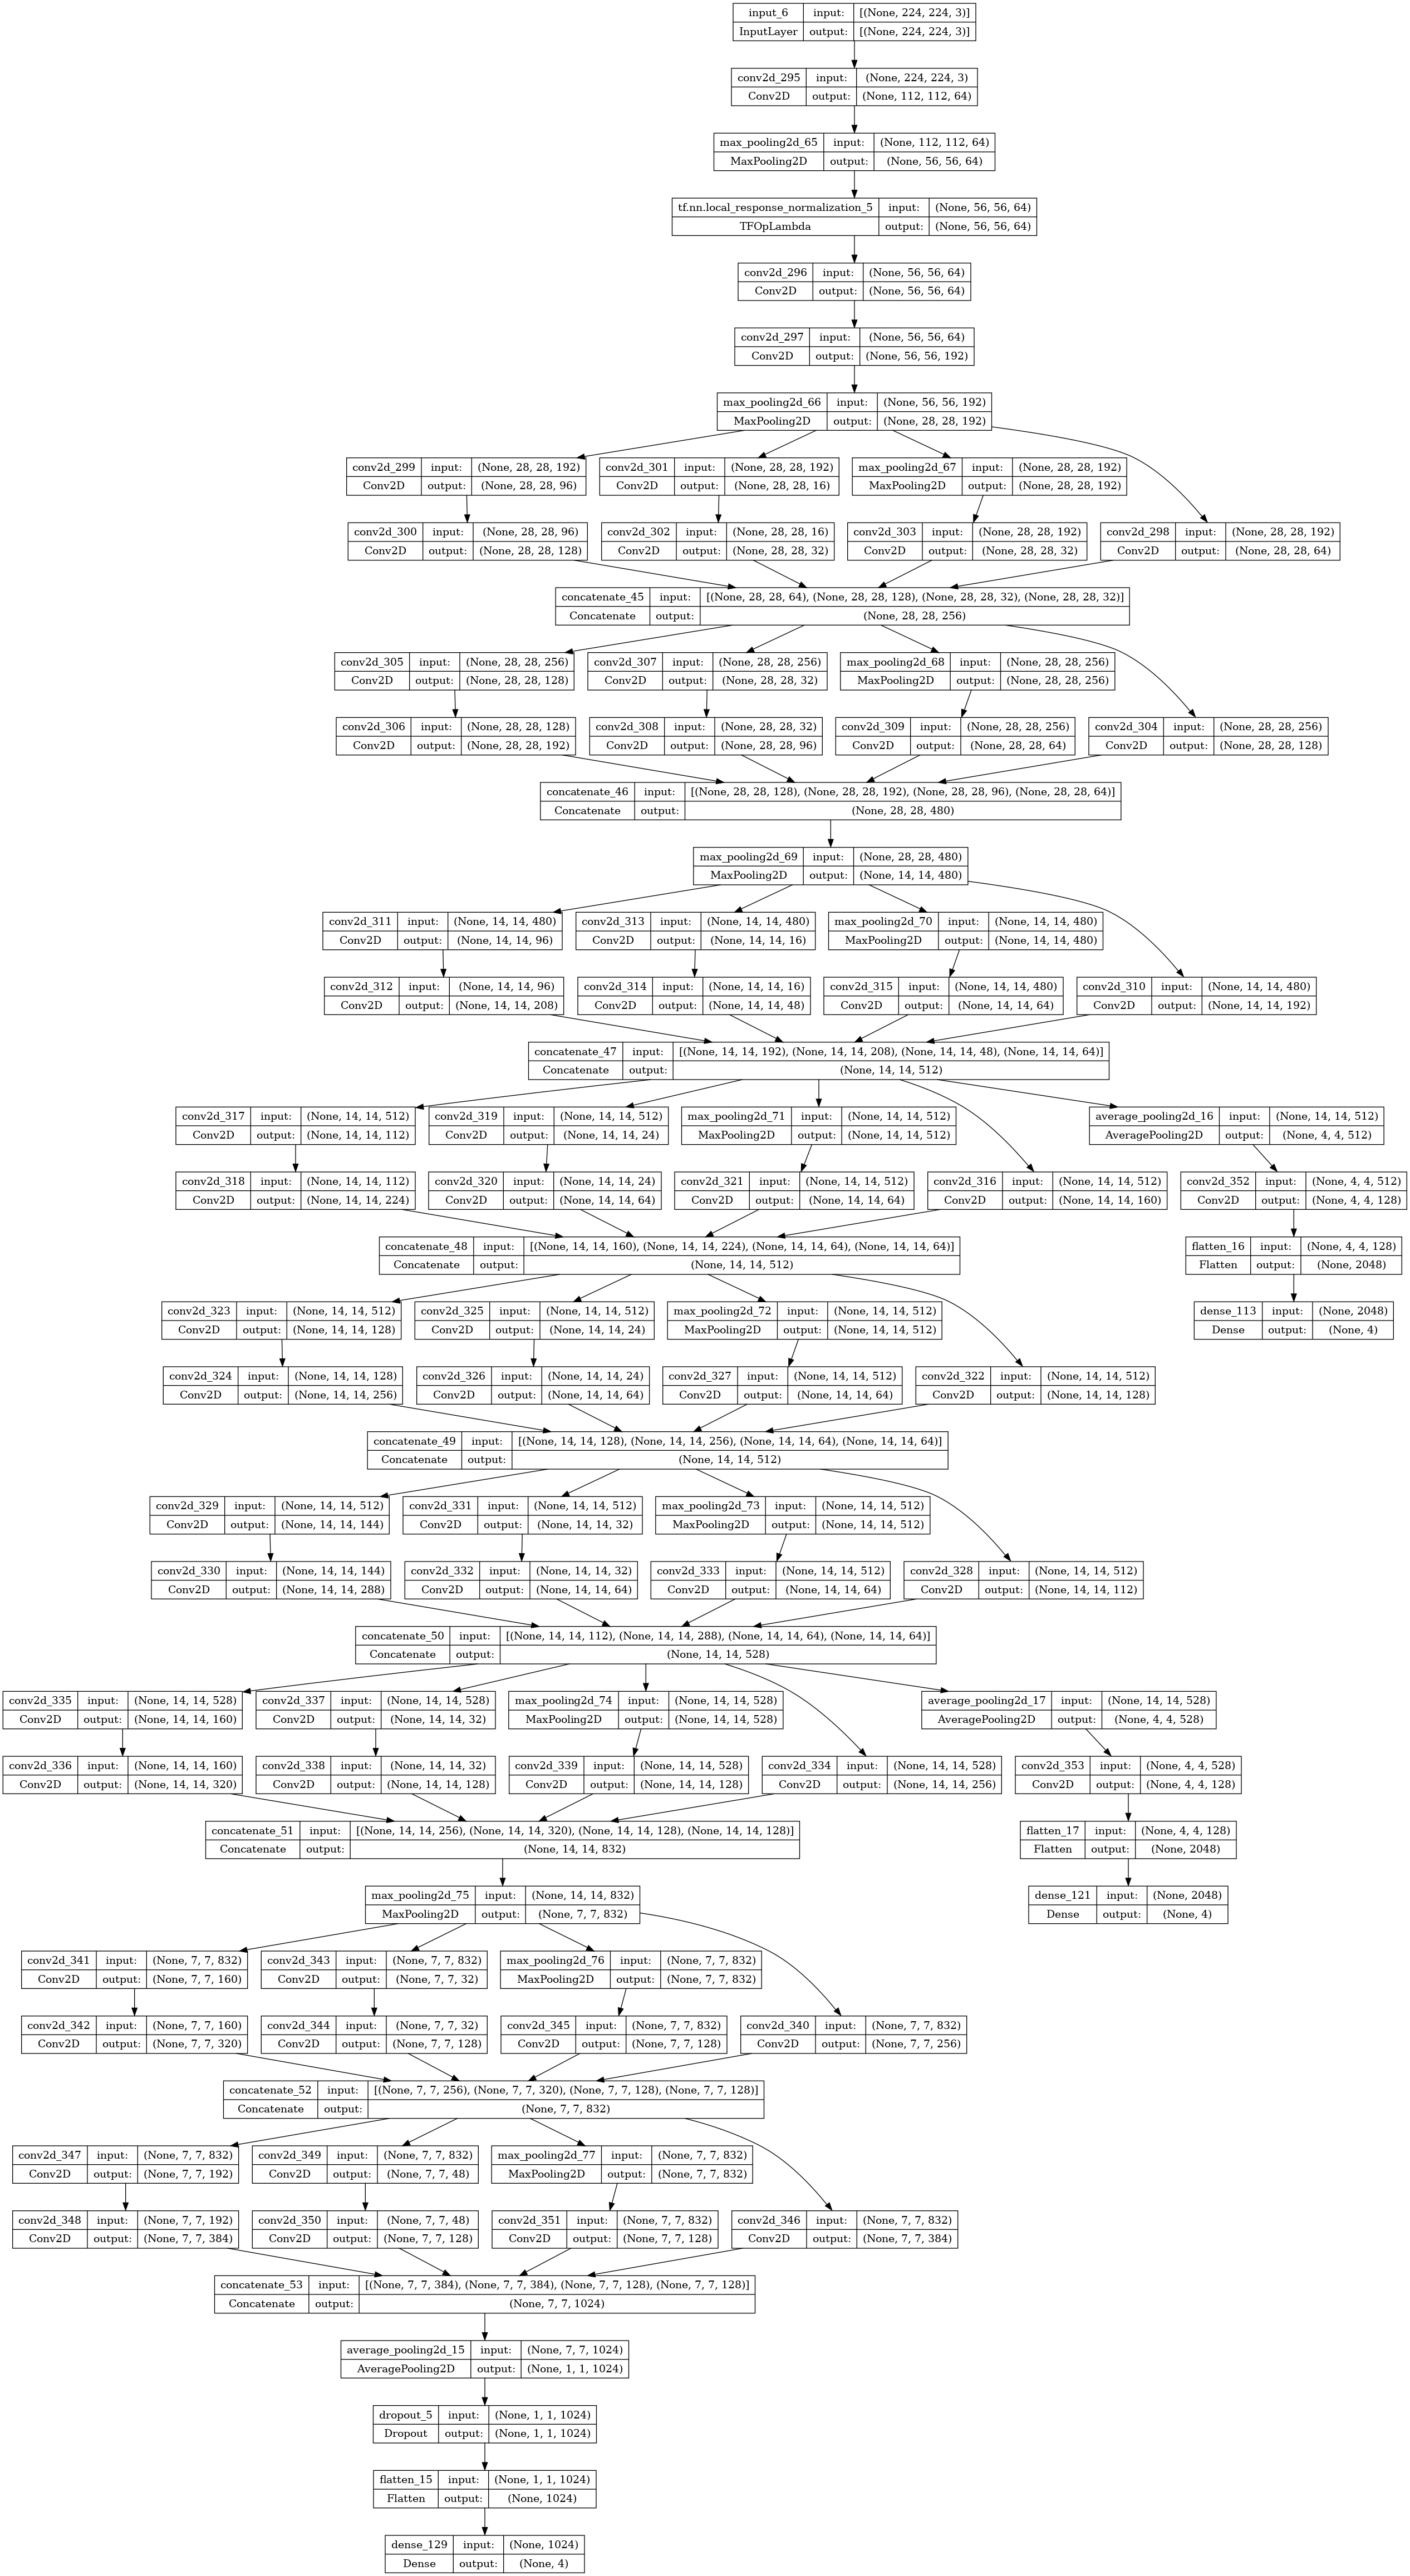

In [38]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False,
)

dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

40/40 [==============================] - 2s 26ms/step
(3, 1280, 4)
(1280,)
(1280, 224, 224, 3)
(1280,)
Classification Report:
                     precision    recall  f1-score   support

     mild_demented       0.84      0.81      0.82       177
 moderate_demented       0.71      0.83      0.77        12
      non_demented       0.90      0.93      0.92       648
very_mild_demented       0.87      0.84      0.85       443

          accuracy                           0.88      1280
         macro avg       0.83      0.85      0.84      1280
      weighted avg       0.88      0.88      0.88      1280



()

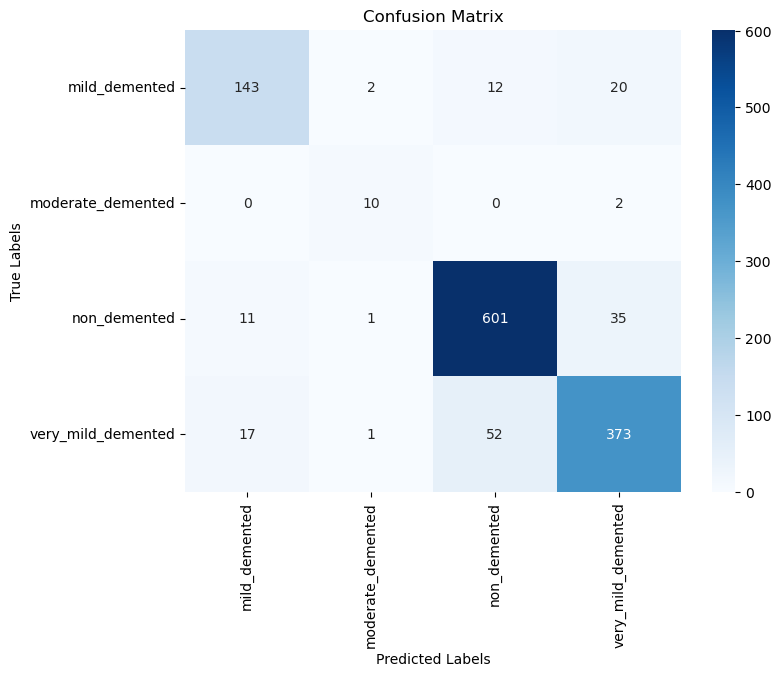

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(X_test)
#print(predictions)
predictions= np.array(predictions)
print(predictions.shape)

# Assuming you have three output layers
output1_predictions = np.argmax(predictions[0], axis=1)
output2_predictions = np.argmax(predictions[1], axis=1)
output3_predictions = np.argmax(predictions[2], axis=1)

# Print the shape and values of the predicted classes
print(output3_predictions.shape)

print(X_test.shape)
print(y_test.shape)

# Generate the classification report
class_names = list(['mild_demented','moderate_demented','non_demented','very_mild_demented'])
report = classification_report(y_test, output3_predictions , target_names=class_names)

print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(y_test, output3_predictions )
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
# The annot=True argument displays the values inside the heatmap cells. 
#fmt="d" specifies that the values should be displayed as integers. 
#The cmap="Blues" argument sets the color map to shades of blue.
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show
()



dict_keys(['loss', 'dense_233_loss', 'dense_241_loss', 'dense_249_loss', 'dense_233_accuracy', 'dense_241_accuracy', 'dense_249_accuracy', 'val_loss', 'val_dense_233_loss', 'val_dense_241_loss', 'val_dense_249_loss', 'val_dense_233_accuracy', 'val_dense_241_accuracy', 'val_dense_249_accuracy', 'lr'])


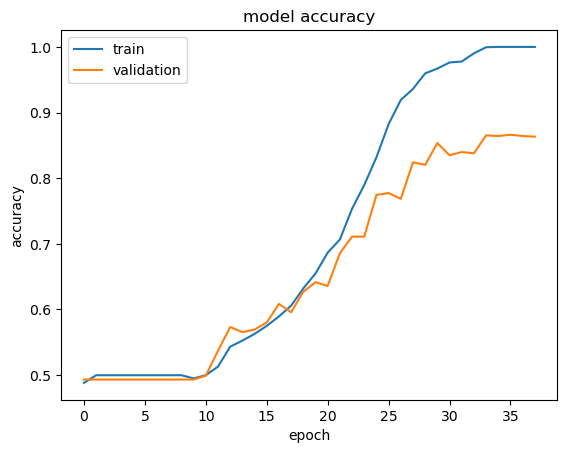

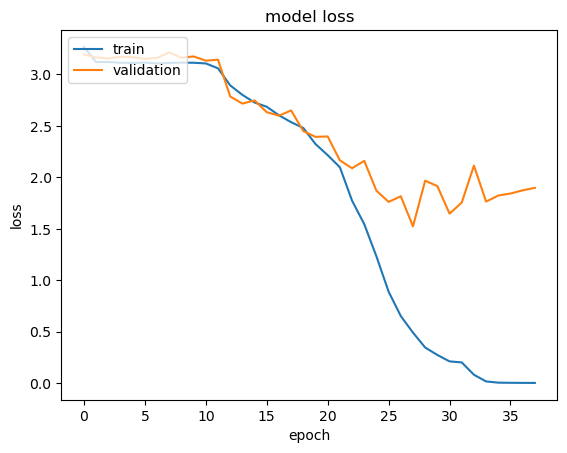

In [54]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['dense_233_accuracy'])
plt.plot(history.history['val_dense_233_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()